# I. Data Setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

seed = 42


def data_import(name):
    """
    Preconditions: Data has NACCID and VISITDATE for every visit.
    """

    df = pd.read_csv(name)
    df = df.sort_values(by=["NACCID", "VISITDATE"])
    print(df.head())

    return df


original_data = data_import("seven_visits_test.csv")
df = original_data

       NACCID   VISITDATE  NACCVNUM  COURSE  patient_id  NACCAVST  interval  \
0  NACC001003  2013-02-19         1       8           6        10         0   
1  NACC001003  2014-03-18         2       8           6        10       392   
2  NACC001003  2015-02-18         3       8           6        10       337   
3  NACC001003  2016-03-09         4       8           6        10       385   
4  NACC001003  2017-02-16         5       8           6        10       344   

    ...8  SEX  HISPANIC  ...  CDRSUM  CDRGLOB NACCUDSD  NACCDAYS  NACCFDYS  \
0  58216    2         0  ...     0.0      0.0        1      3311       0.0   
1  58217    2         0  ...     0.0      0.0        1      3311     392.0   
2  58218    2         0  ...     0.0      0.0        1      3311     729.0   
3  58219    2         0  ...     0.0      0.0        1      3311    1114.0   
4  58220    2         0  ...     0.0      0.0        1      3311    1458.0   

   VISITDAY  VISITMO  VISITYR  visitorder  NACCADC  
0  

# II. Feature Engineering (skip, doesn't work yet)

In [2]:
# Helper functions for finding longitudinal-derived features
import numpy as np
from scipy import stats
from sklearn.metrics import auc


def check_time_varying(feat, time_varying_list):
    if feat.split("_")[0] in time_varying_list:
        return True
    return False


def cat_feat_over_time(df, baseline, feat):
    # Calculate the time for the subjects in the dataset
    time_total = df.groupby(["NACCID"])[["VISITYR"]].max() - df.groupby(["NACCID"])[["VISITYR"]].min()
    # Calculate the change rate - p_flip
    change_feat = feat + "_rate"
    baseline[change_feat] = df.groupby(["NACCID"])[[feat]].diff().groupby(["NACCID"]).apply(
                            lambda gr: gr[gr[feat] != 0].count()).values.ravel() / time_total.values.ravel()  # over time
    # Calculate the SD
    # sd_feat = feat + '_sd'
    # baseline[sd_feat] = df.groupby(['NACCID'])[[feat]].std(ddof=0) # population SD to avoid NaNs
    # Calculate the mode
    mode_feat = feat + "_mode"
    baseline[mode_feat] = df.groupby(["NACCID"])[feat].agg(lambda gr: pd.Series.mode(gr)[0])
    return baseline


def ord_feat_over_time(df, baseline, feat):
    # Calculate the time for the subjects in the dataset
    time_total = df.groupby(["NACCID"])[["VISITYR"]].max() - df.groupby(["NACCID"])[["VISITYR"]].min()
    # Calculate the max change over time
    change_feat = feat + "_change"
    baseline[change_feat] = (df.groupby(["NACCID"])[[feat]].max() - df.groupby(["NACCID"])[[feat]].min()).values.ravel() / time_total.values.ravel()  # over time
    # Calculate the change rate - p_flip
    rate_feat = feat + "_rate"
    baseline[rate_feat] = df.groupby(["NACCID"])[[feat]].diff().groupby(["NACCID"]).apply(
                            lambda gr: gr[gr[feat] != 0].count()).values.ravel() / time_total.values.ravel()  # over time
    # Calculate the mean
    mean_feat = feat + "_mean"
    baseline[mean_feat] = df.groupby(["NACCID"])[[feat]].mean()
    # Calculate the area under the curve (AUC)
    auc_feat = feat + "_auc"
    for subj in df.index.unique():
        x = df.loc[subj, "VISITYR"].sort_values().values
        y = df.loc[subj, [feat, "VISITYR"]].sort_values(by=["VISITYR"]).drop(columns=["VISITYR"]).values.ravel()
        baseline.loc[subj, auc_feat] = auc(x, y)
    return baseline


def num_feat_over_time(df, baseline, feat):
    # Calculate the max change (not normalized by time)
    change_feat = feat + "_change"
    baseline[change_feat] = df.groupby(["NACCID"])[[feat]].max() - df.groupby(["NACCID"])[[feat]].min()
    # Calculate the SD
    sd_feat = feat + "_var"
    baseline[sd_feat] = df.groupby(["NACCID"])[[feat]].var()
    # Calculate the mean
    mean_feat = feat + "_mean"
    baseline[mean_feat] = df.groupby(["NACCID"])[[feat]].mean()
    # Calculate the slope
    slope_feat = feat + "_slope"
    # Calculate the area under the curve (AUC)
    auc_feat = feat + "_auc"
    for subj in df.index.unique():
        slope, intecept, r_value, p_value, std_err = stats.linregress(df.loc[subj, "VISITYR"].sort_values().values,  # sorts visits from -7 to -
                df.loc[subj, [feat, "VISITYR"]].sort_values(by=["VISITYR"]).drop(columns=["VISITYR"]).values.ravel())  # to calculate the correct slope
        baseline.loc[subj, slope_feat] = slope
        x = df.loc[subj, "VISITYR"].sort_values().values
        y = df.loc[subj, [feat, "VISITYR"]].sort_values(by=["VISITYR"]).drop(columns=["VISITYR"]).values.ravel()
        baseline.loc[subj, auc_feat] = auc(x, y)
    return baseline


def get_feature_types(df, tier2=True):
    # one hot encode, without dropping categories
    cat_demo_feats = ["NACCNIHR", "PRIMLANG", "SEX", "HISPANIC"]
    ord_demo_feats = ["MARISTAT", "NACCLIVS", "INDEPEND", "RESIDENC"]
    num_demo_feats = ["NACCAGE", "EDUC"]

    cat_phist_feats = ["TOBAC30", "TOBAC100", "NACCTBI", "DEP2YRS", "DEPOTHR",
            "ANYMEDS", "NACCAAAS", "NACCAANX", "NACCAC", "NACCACEI",
            "NACCADEP", "NACCAHTN", "NACCANGI", "NACCAPSY",
            "NACCBETA", "NACCCCBS", "NACCDBMD", "NACCDIUR", "NACCEMD",
            "NACCEPMD", "NACCHTNC", "NACCLIPL", "NACCNSD", "NACCPDMD",
            "NACCVASD"]
    ord_phist_feats = ["NACCAMD", "PACKSPER", "CVHATT", "CVAFIB", "CVANGIO", "CVBYPASS", "CBTIA",
            "CVPACE", "CVCHF", "CVOTHR", "CBSTROKE", "SEIZURES", "NCOTHR",
            "DIABETES", "HYPERTEN", "HYPERCHO", "B12DEF", "THYROID", "INCONTU",
            "INCONTF", "ALCOHOL", "ABUSOTHR", "PSYCDIS"]
    num_phist_feats = ["SMOKYRS", "NACCSTYR", "NACCTIYR"]

    cat_fhist_feats = ["NACCFADM", "NACCFFTD"]
    ord_fhist_feats = ["NACCFAM", "NACCMOM", "NACCDAD"]

    cat_phys_feats = ["NACCNREX", "FOCLSYM", "FOCLSIGN"]
    ord_phys_feats = ["DECSUB", "VISION", "VISCORR", "VISWCORR", "HEARING", "HEARAID", "HEARWAID"]  # 'APOERISK'
    num_phys_feats = ["HEIGHT", "WEIGHT", "BPSYS", "BPDIAS", "HRATE", "NACCBMI"]

    ord_gds_feats = ["NOGDS",  # -4 = NaN - binary
            "SATIS", "DROPACT", "EMPTY", "BORED", "SPIRITS", "AFRAID",
            "HAPPY", "HELPLESS", "STAYHOME", "MEMPROB", "WONDRFUL", "WRTHLESS",
            "ENERGY", "HOPELESS", "BETTER",  # recode 9 as -1, -4 = NaN - ordinal
            "NACCGDS"]  # 88 or -4 = NaN - ordinal
    ord_faq_feats = ["BILLS", "TAXES", "SHOPPING", "GAMES", "STOVE",
            "MEALPREP", "EVENTS", "PAYATTN", "REMDATES", "TRAVEL"]  # recode 8 as -1, 9 or -4 = NaN
    # Decide to drop the binary variables in NPI
    ord_npi_feats = ["DELSEV", "HALLSEV", "AGITSEV", "DEPDSEV", "ANXSEV",
                "ELATSEV", "APASEV", "DISNSEV", "IRRSEV", "MOTSEV", "NITESEV",
                "APPSEV"]

    ord_np_feats = ["MMSEORDA", "MMSEORLO"]

    label_feat = ["NACCUDSD"]
    cdr_feats = ["MEMORY", "ORIENT", "JUDGMENT", "COMMUN", "HOMEHOBB",
                        "PERSCARE", "CDRSUM", "CDRGLOB"]

    # combined
    cat_feats = cat_demo_feats + cat_phist_feats + cat_fhist_feats + cat_phys_feats
    if tier2:
        num_np_feats = ["NACCMMSE", "MEMUNITS", "DIGIF", "DIGIFLEN", "DIGIB", "DIGIBLEN",
                    "ANIMALS", "VEG", "BOSTON", "TRAILA", "TRAILB"]
    else:
        num_np_feats = ["NACCMMSE"]
    ord_feats = list(ord_demo_feats + ord_phist_feats + ord_fhist_feats + ord_phys_feats +
                    ord_npi_feats + ord_gds_feats + ord_faq_feats + ord_np_feats)
    num_feats = num_demo_feats + num_phist_feats + num_phys_feats + num_np_feats

    # check that the features are in the dataframe, updated to handle situations with already-encoded features
    cat_feats = [x for x in df.columns.values if x.split("_")[0] in cat_feats]  # [x for x in cat_feats if x in df.columns.values]
    ord_feats = [x for x in ord_feats if x in df.columns.values]
    num_feats = [x for x in num_feats if x in df.columns.values]
    label_feat = [x for x in label_feat if x in df.columns.values]
    cdr_feats = [x for x in cdr_feats if x in df.columns.values]
    return cat_feats, ord_feats, num_feats, label_feat, cdr_feats


if __name__ == "__main__":
    # Add in longitudinal-derived features

    # Load the dataset -- not included in this code
    baseline_df = pd.read_csv("seven_visits_new.csv")
    # Here df is a general dataset with all the visits, but you will also need
    # to make a baseline_df to store the baseline + longitudinal-derived features
    cat_feats, ord_feats, num_feats, _, _ = get_feature_types(df)

    # Load list of features that are time-varying
    # file_dir = '/GitHub/Project/'
    file_dir = ""
    time_varying_df = pd.read_excel(file_dir + "feature_details.xlsx", index_col=0, header=0)
    time_varying_df = time_varying_df[["time-varying"]].rename_axis(index="Feature")
    time_varying_list = time_varying_df[time_varying_df["time-varying"] == 1].index.values

    for feat in df.columns.values:
        # check that the feature is not cross-sectional (unchanging over time)
        if check_time_varying(feat, time_varying_list):
            if feat in cat_feats:
                baseline_df = cat_feat_over_time(df, baseline_df, feat)
            if feat in ord_feats:
                baseline_df = ord_feat_over_time(df, baseline_df, feat)
            if feat in num_feats:
                baseline_df = num_feat_over_time(df, baseline_df, feat)

    # Save the baseline_df with the longitudinal-derived features
    baseline_df.to_csv("baseline_df.csv")

ValueError: Length of values (848) does not match length of index (29666)

# conversion to float, dropping nans, flattening, etc...


In [3]:
import pandas as pd


def date_to_float(date_str):
    try:
        date_obj = pd.to_datetime(date_str, format="%Y-%m-%d")
        return float(date_obj.strftime("%Y%1m%d"))
    except ValueError:
        return float("nan")


df["VISITDATE"] = df["VISITDATE"].apply(date_to_float)

In [4]:
# THE SECOND FLATTENED DF - COLUMNS FROM THE SAME ROW ARE PUT NEXT TO ONE ANOTHER.

def process_data(df, start, end):
    df = df.sort_values(by=["NACCID", "VISITDATE"])

    # Determine the TRUTH value for each NACCID
    truth_map = {}
    for naccid, group in df.groupby("NACCID"):
        # Get the NACCUDSD value at the <start> position
        start_naccudsd = group.iloc[start - 1]["NACCUDSD"] if start - 1 < len(group) else None

        # Check subsequent NACCUDSD values
        truth = any(group.iloc[start:]["NACCUDSD"] > start_naccudsd)
        truth_map[naccid] = int(truth)

    # Step 2: Flatten the dataset to include only up to the first <start> rows for each NACCID
    flattened_rows = []
    for naccid, group in df.groupby("NACCID"):
        flattened_row = group.iloc[:(start + 1)].to_dict("records")

        # FLATTENING
        flattened_dict = {f"{key}_{idx + 1}": value for idx, row in enumerate(flattened_row) for key, value in row.items()}
        flattened_rows.append(flattened_dict)

    flattened_df = pd.DataFrame(flattened_rows)

    # Step 3: Append the TRUTH column
    flattened_df["TRUTH"] = flattened_df["NACCID_1"].map(truth_map)

    # Ensure NACCID appears only once and reset the index
    flattened_df = flattened_df.drop_duplicates(subset=["NACCID_1"]).reset_index(drop=True)

    return flattened_df



In [5]:

# This code is to split train/test our original dataset.
# Currently split size is set to 100% for train because I'm using nested CV. Flat_train_df is the whole dataset

subject_ids = df["NACCID"].unique()
np.random.seed(seed)
np.random.shuffle(subject_ids)


split_size = int(len(subject_ids) * 1)
train_ids = subject_ids[:split_size]
test_ids = subject_ids[split_size:]


train_df_pre = df[df["NACCID"].isin(train_ids)]
test_df_pre = df[df["NACCID"].isin(test_ids)]


flat_train_df = process_data(train_df_pre, 3, 6)
# flat_test_df = process_data(test_df_pre, 1, 6)
flat_train_df

,NACCID_1,VISITDATE_1,NACCVNUM_1,COURSE_1,patient_id_1,NACCAVST_1,interval_1,...8_1,SEX_1,HISPANIC_1,...,CDRGLOB_4,NACCUDSD_4,NACCDAYS_4,NACCFDYS_4,VISITDAY_4,VISITMO_4,VISITYR_4,visitorder_4,NACCADC_4,TRUTH
0,NACC001003,NaN,1,8,6,10,0,58216,2,0,...,0.0,1,3311,1114.0,9,3,2016,4,3630,0
1,NACC003058,NaN,5,1,14,12,367,72585,2,1,...,1.0,4,4420,2734.0,10,4,2018,8,4935,0
2,NACC005563,NaN,1,1,22,7,0,78492,2,0,...,1.0,4,2151,1047.0,3,4,2009,4,4967,0
3,NACC012212,NaN,1,8,47,9,0,148267,2,0,...,0.0,1,2926,1099.0,27,4,2011,4,8658,0
4,NACC012693,NaN,1,1,50,9,0,40604,2,1,...,0.5,3,2961,1092.0,24,3,2014,4,2289,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,NACC993800,NaN,1,1,4214,8,0,61778,1,0,...,1.0,4,2546,1140.0,16,9,2015,4,3630,0
844,NACC994354,NaN,1,8,4215,16,0,148004,1,0,...,0.0,1,5865,1084.0,10,9,2009,4,8646,0
845,NACC995306,NaN,1,1,4218,9,0,97944,2,0,...,1.0,4,3402,1076.0,13,4,2015,4,5452,0
846,NACC997010,NaN,1,8,4225,7,0,78389,2,1,...,0.0,1,2367,1261.0,13,7,2011,4,4935,0


In [6]:
import pandas as pd


def columns_with_non_float_values(df):
    non_float_columns = []

    for column in df.columns:
        try:
            df[column].astype(float)
        except ValueError:
            non_float_columns.append(column)

    return non_float_columns


non_float_columns = columns_with_non_float_values(flat_train_df)

flat_train_df = flat_train_df.drop(columns=non_float_columns)

print("dropping: ")
non_float_columns

dropping: 


['NACCID_1',
 'RACEX_1',
 'NACCAMX_1',
 'NACCAMSX_1',
 'NACCFMX_1',
 'NACCFMSX_1',
 'NACCOMX_1',
 'NACCOMSX_1',
 'PSYCDISX_1',
 'NPIQINFX_1',
 'NACCID_2',
 'RACEX_2',
 'NACCAMX_2',
 'NACCAMSX_2',
 'NACCFMX_2',
 'NACCFMSX_2',
 'NACCOMX_2',
 'NACCOMSX_2',
 'PSYCDISX_2',
 'NPIQINFX_2',
 'NACCID_3',
 'RACEX_3',
 'NACCAMX_3',
 'NACCAMSX_3',
 'NACCFMX_3',
 'NACCFMSX_3',
 'NACCOMX_3',
 'NACCOMSX_3',
 'PSYCDISX_3',
 'NPIQINFX_3',
 'NACCID_4',
 'RACEX_4',
 'NACCAMX_4',
 'NACCAMSX_4',
 'NACCFMX_4',
 'NACCFMSX_4',
 'NACCOMX_4',
 'NACCOMSX_4',
 'PSYCDISX_4',
 'NPIQINFX_4']

In [7]:
# Dropping NaN columns

flat_train_df = flat_train_df.dropna(axis=1)
flat_train_df["TRUTH"] = flat_train_df["TRUTH"].astype(int)
flat_train_df

,NACCVNUM_1,COURSE_1,patient_id_1,NACCAVST_1,interval_1,...8_1,SEX_1,HISPANIC_1,RACE_1,PRIMLANG_1,...,CDRGLOB_4,NACCUDSD_4,NACCDAYS_4,NACCFDYS_4,VISITDAY_4,VISITMO_4,VISITYR_4,visitorder_4,NACCADC_4,TRUTH
0,1,8,6,10,0,58216,2,0,1,1,...,0.0,1,3311,1114.0,9,3,2016,4,3630,0
1,5,1,14,12,367,72585,2,1,1,2,...,1.0,4,4420,2734.0,10,4,2018,8,4935,0
2,1,1,22,7,0,78492,2,0,1,1,...,1.0,4,2151,1047.0,3,4,2009,4,4967,0
3,1,8,47,9,0,148267,2,0,1,1,...,0.0,1,2926,1099.0,27,4,2011,4,8658,0
4,1,1,50,9,0,40604,2,1,50,2,...,0.5,3,2961,1092.0,24,3,2014,4,2289,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,1,1,4214,8,0,61778,1,0,1,1,...,1.0,4,2546,1140.0,16,9,2015,4,3630,0
844,1,8,4215,16,0,148004,1,0,1,1,...,0.0,1,5865,1084.0,10,9,2009,4,8646,0
845,1,1,4218,9,0,97944,2,0,1,1,...,1.0,4,3402,1076.0,13,4,2015,4,5452,0
846,1,8,4225,7,0,78389,2,1,1,1,...,0.0,1,2367,1261.0,13,7,2011,4,4935,0


In [8]:
# If you're using train/test

# common_columns = flat_train_df.columns.intersection(flat_test_df.columns)

# flat_test_df = flat_test_df[common_columns]

In [9]:
flat_train_df

,NACCVNUM_1,COURSE_1,patient_id_1,NACCAVST_1,interval_1,...8_1,SEX_1,HISPANIC_1,RACE_1,PRIMLANG_1,...,CDRGLOB_4,NACCUDSD_4,NACCDAYS_4,NACCFDYS_4,VISITDAY_4,VISITMO_4,VISITYR_4,visitorder_4,NACCADC_4,TRUTH
0,1,8,6,10,0,58216,2,0,1,1,...,0.0,1,3311,1114.0,9,3,2016,4,3630,0
1,5,1,14,12,367,72585,2,1,1,2,...,1.0,4,4420,2734.0,10,4,2018,8,4935,0
2,1,1,22,7,0,78492,2,0,1,1,...,1.0,4,2151,1047.0,3,4,2009,4,4967,0
3,1,8,47,9,0,148267,2,0,1,1,...,0.0,1,2926,1099.0,27,4,2011,4,8658,0
4,1,1,50,9,0,40604,2,1,50,2,...,0.5,3,2961,1092.0,24,3,2014,4,2289,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,1,1,4214,8,0,61778,1,0,1,1,...,1.0,4,2546,1140.0,16,9,2015,4,3630,0
844,1,8,4215,16,0,148004,1,0,1,1,...,0.0,1,5865,1084.0,10,9,2009,4,8646,0
845,1,1,4218,9,0,97944,2,0,1,1,...,1.0,4,3402,1076.0,13,4,2015,4,5452,0
846,1,8,4225,7,0,78389,2,1,1,1,...,0.0,1,2367,1261.0,13,7,2011,4,4935,0


In [10]:
def transform_data(df, start, end):
    df["VISITDATE"] = df["VISITDATE"].apply(date_to_float)

    subject_ids = df["NACCID"].unique()
    np.random.seed(seed)
    np.random.shuffle(subject_ids)

    split_size = int(len(subject_ids) * 1)
    train_ids = subject_ids[:split_size]
    test_ids = subject_ids[split_size:]

    train_df_pre = df[df["NACCID"].isin(train_ids)]
    test_df_pre = df[df["NACCID"].isin(test_ids)]

    flat_train_df = process_data(df, start, end)

    non_float_columns = columns_with_non_float_values(flat_train_df)
    flat_train_df = flat_train_df.drop(columns=non_float_columns)

    flat_train_df = flat_train_df.dropna(axis=1)
    flat_train_df["TRUTH"] = flat_train_df["TRUTH"].astype(int)
    return flat_train_df


In [11]:
full_df = transform_data(original_data, 1, 6)

# V. Testing Pipelines

# Nested CV: Pipline 🎯

In [12]:
X = full_df.drop(["TRUTH"], axis=1)
y = full_df["TRUTH"]

# Neural Net

In [26]:
pip install scikit-learn==1.2.2 imblearn

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.2.2-cp310-cp310-win_amd64.whl (8.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imblearnPipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier


class NeuralNetworkClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layer_sizes=(100,), activation="relu", solver="adam", alpha=0.0001, learning_rate="constant", learning_rate_init=0.001):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.solver = solver
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init

    def fit(self, X, y):
        self.model_ = MLPClassifier(
            hidden_layer_sizes=self.hidden_layer_sizes,
            activation=self.activation,
            solver=self.solver,
            alpha=self.alpha,
            learning_rate=self.learning_rate,
            learning_rate_init=self.learning_rate_init,
        )
        self.model_.fit(X, y)
        return self

    def predict(self, X):
        return self.model_.predict(X)

    def score(self, X, y):
        predictions = self.predict(X)
        return balanced_accuracy_score(y, predictions)

    def predict_proba(self, X):
        return self.model_.predict_proba(X)


# imblearn pipeline with the neural network classifier
nn_smote_pipeline = imblearnPipeline([
    ("smote", SMOTE()),
    ("nn_classifier", NeuralNetworkClassifier()),
])

# Adjusted parameter grid for the neural network
param_grid_nn = {
    "smote__sampling_strategy": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "nn_classifier__hidden_layer_sizes": [(50,), (100,), (100, 50), (100, 100)],
    "nn_classifier__activation": ["tanh", "relu"],
    "nn_classifier__solver": ["sgd", "adam"],
    "nn_classifier__alpha": [0.0001, 0.001, 0.01],
}

# Example using GridSearchCV
# nn_pipeline = GridSearchCV(nn_smote_pipeline, param_grid_nn, scoring=make_scorer(balanced_accuracy_score), cv=5)
# nn_pipeline.fit(X_train, y_train)

# Example using HalvingRandomSearchCV
# nn_pipeline = HalvingRandomSearchCV(nn_smote_pipeline, param_grid_nn, scoring=make_scorer(balanced_accuracy_score), cv=5, random_state=42, n_jobs=-1)

# Note: Before running the fitting process, ensure you have your data divided into X_train and y_train.
# After fitting, you can use nn_pipeline.best_params_ and nn_pipeline.best_score_ to see the best parameters and score.


In [17]:
import numpy as np
from sklearn.model_selection import KFold


def nested_cv_pipeline(X, y, pipeline, param):
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    outer_scores = []
    best_params_outer = []

    i = 0
    for train_idx, test_idx in outer_cv.split(X):

        print(i)

        i += 1

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        grid_search = GridSearchCV(pipeline, param, scoring=make_scorer(balanced_accuracy_score), cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_params_outer.append(grid_search.best_params_)

        best_model = grid_search.best_estimator_
        test_score = best_model.score(X_test, y_test)
        outer_scores.append(test_score)

    print("Outer CV scores: ", outer_scores)
    print("Mean balanced accuracy score: ", np.mean(outer_scores))
    print("Best parameters for each outer fold: ", best_params_outer)


# visit = 1
# full_df = transform_data(original_data, visit, 6)
# print("start visit: " + str(visit))
# X = full_df.drop(['TRUTH'], axis = 1)
# y = full_df['TRUTH']

# nested_cv_pipeline(X, y, nn_smote_pipeline, param_grid_nn)

In [20]:
for visit in range(1, 5):
    full_df = transform_data(original_data, visit, 6)
    print("start visit: " + str(visit))
    X = full_df.drop(["TRUTH"], axis=1)
    y = full_df["TRUTH"]

    nested_cv_pipeline(X, y, nn_smote_pipeline, param_grid_nn)

start visit: 1
0
1
2
3
4
Outer CV scores:  [0.511204481792717, 0.5113636363636364, 0.49224806201550386, 0.5345655806182121, 0.4925880711545169]
Mean balanced accuracy score:  0.5083939663889173
Best parameters for each outer fold:  [{'nn_classifier__activation': 'relu', 'nn_classifier__alpha': 0.001, 'nn_classifier__hidden_layer_sizes': (50,), 'nn_classifier__solver': 'adam', 'smote__sampling_strategy': 1}, {'nn_classifier__activation': 'relu', 'nn_classifier__alpha': 0.01, 'nn_classifier__hidden_layer_sizes': (100, 100), 'nn_classifier__solver': 'adam', 'smote__sampling_strategy': 0.9}, {'nn_classifier__activation': 'relu', 'nn_classifier__alpha': 0.001, 'nn_classifier__hidden_layer_sizes': (100, 50), 'nn_classifier__solver': 'adam', 'smote__sampling_strategy': 1}, {'nn_classifier__activation': 'relu', 'nn_classifier__alpha': 0.01, 'nn_classifier__hidden_layer_sizes': (50,), 'nn_classifier__solver': 'adam', 'smote__sampling_strategy': 0.5}, {'nn_classifier__activation': 'relu', 'nn_cl


KeyboardInterrupt



## GradBoost: Imblearn pipeline SMOTE

In [31]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imblearnPipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import HalvingRandomSearchCV


class GradientBoostingEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, gb_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1.0):
        self.gb_estimators = gb_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.subsample = subsample

    def fit(self, X, y):
        self.model_ = GradientBoostingClassifier(
            n_estimators=self.gb_estimators,
            learning_rate=self.learning_rate,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            subsample=self.subsample,
        )
        self.model_.fit(X, y)
        return self

    def predict(self, X):
        return self.model_.predict(X)

    def score(self, X, y):
        predictions = self.predict(X)
        return balanced_accuracy_score(y, predictions)

    def predict_proba(self, X):
        return self.model_.predict_proba(X)


# imblearn pipeline
gradboost_smote_pipeline = imblearnPipeline([
    ("smote", SMOTE()),
    ("gb_estimator", GradientBoostingEstimator()),
])

param_grid = {
    "smote__sampling_strategy": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "gb_estimator__gb_estimators": range(100, 500, 100),
    "gb_estimator__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "gb_estimator__max_depth": [3, 5, 7, 9],
    # 'gb_estimator__min_samples_split': [2, 5, 10],
    # 'gb_estimator__min_samples_leaf': [1, 2, 4],
    # 'gb_estimator__subsample': [0.8, 0.9, 1.0]
}

# grad_boost_pipeline = HalvingRandomSearchCV(gradboost_smote_pipeline, param_grid, scoring=make_scorer(balanced_accuracy_score), cv=5, random_state=42, n_jobs=-1)


# grad_boost_pipeline = GridSearchCV(gradboost_smote_pipeline, param_grid, scoring=make_scorer(balanced_accuracy_score), cv=5)
# grad_boost_pipeline.fit(X_train, y_train)

# # Output the best parameters and corresponding score
# print("Best parameters found: ", grad_boost_pipeline.best_params_)
# print("Best balanced accuracy score: ", grad_boost_pipeline.best_score_)


In [35]:
import numpy as np


def nested_cv_pipeline(X, y, pipeline, param):
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    outer_scores = []
    best_params_outer = []

    i = 0
    for train_idx, test_idx in outer_cv.split(X):

        print(i)

        i += 1

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        grid_search = GridSearchCV(pipeline, param, scoring=make_scorer(balanced_accuracy_score), cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_params_outer.append(grid_search.best_params_)

        best_model = grid_search.best_estimator_
        test_score = best_model.score(X_test, y_test)
        outer_scores.append(test_score)

    print("Outer CV scores: ", outer_scores)
    print("Mean balanced accuracy score: ", np.mean(outer_scores))
    print("Best parameters for each outer fold: ", best_params_outer)


In [ ]:
for visit in range(1, 5):
    full_df = transform_data(original_data, visit, 6)
    print("start visit: " + str(visit))
    X = full_df.drop(["TRUTH"], axis=1)
    y = full_df["TRUTH"]

    nested_cv_pipeline(X, y, gradboost_smote_pipeline, param_grid)

start visit: 1
0
1
2
3
4
Outer CV scores:  [0.6596638655462185, 0.6517145135566188, 0.7201739459255058, 0.6534043441938179, 0.704482036972445]
Mean balanced accuracy score:  0.6778877412389213
Best parameters for each outer fold:  [{'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 3, 'smote__sampling_strategy': 1}, {'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 3, 'smote__sampling_strategy': 0.8}, {'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.05, 'gb_estimator__max_depth': 3, 'smote__sampling_strategy': 1}, {'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 3, 'smote__sampling_strategy': 0.9}, {'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 3, 'smote__sampling_strategy': 0.9}]
start visit: 2
0
1
2
3
4
Outer CV scores:  [0.6149248633879781, 0.5849184782608696

In [22]:
full_df = transform_data(original_data, 1, 6)

"""
Start visit: 1
Outer CV scores:  [0.6596638655462185, 0.6517145135566188, 0.7201739459255058, 0.6534043441938179, 0.704482036972445]
Mean balanced accuracy score:  0.6778877412389213
Best parameters for each outer fold:  [{'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 3, 'smote__sampling_strategy': 1}, {'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 3, 'smote__sampling_strategy': 0.8}, {'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.05, 'gb_estimator__max_depth': 3, 'smote__sampling_strategy': 1}, {'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 3, 'smote__sampling_strategy': 0.9}, {'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 3, 'smote__sampling_strategy': 0.9}]

Start visit: 2
Outer CV scores:  [0.6149248633879781, 0.5849184782608696, 0.7625598086124402, 0.655223880597015, 0.6740658899156288]
Mean balanced accuracy score:  0.6583385841547864
Best parameters for each outer fold:  [{'gb_estimator__gb_estimators': 300, 'gb_estimator__learning_rate': 0.05, 'gb_estimator__max_depth': 7, 'smote__sampling_strategy': 0.9}, {'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 3, 'smote__sampling_strategy': 1}, {'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 3, 'smote__sampling_strategy': 1}, {'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 9, 'smote__sampling_strategy': 0.8}, {'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 5, 'smote__sampling_strategy': 1}]

Start visit: 3
Outer CV scores:  [0.7166269913935177, 0.6045487894350696, 0.660797260943996, 0.6279342723004695, 0.7062043795620438]
Mean balanced accuracy score:  0.6632223387270193
Best parameters for each outer fold:  [{'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 5, 'smote__sampling_strategy': 0.9}, {'gb_estimator__gb_estimators': 100, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 3, 'smote__sampling_strategy': 0.9}, {'gb_estimator__gb_estimators': 200, 'gb_estimator__learning_rate': 0.1, 'gb_estimator__max_depth': 7, 'smote__sampling_strategy': 0.8}, {'gb_estimator__gb_estimators': 200, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 7, 'smote__sampling_strategy': 1}, {'gb_estimator__gb_estimators': 200, 'gb_estimator__learning_rate': 0.01, 'gb_estimator__max_depth': 5, 'smote__sampling_strategy': 0.9}]


"""

training...
5      1
7      1
10     0
23     0
29     1
      ..
838    1
842    0
843    0
844    0
846    0
Name: TRUTH, Length: 170, dtype: int32


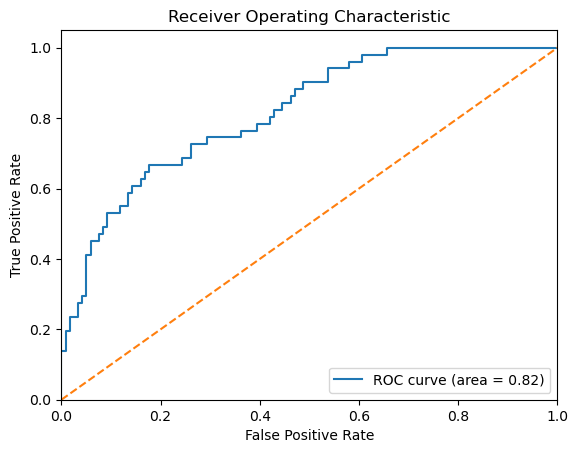

training...
2      1
6      0
11     1
18     1
24     0
      ..
812    0
813    0
814    0
824    0
840    1
Name: TRUTH, Length: 170, dtype: int32


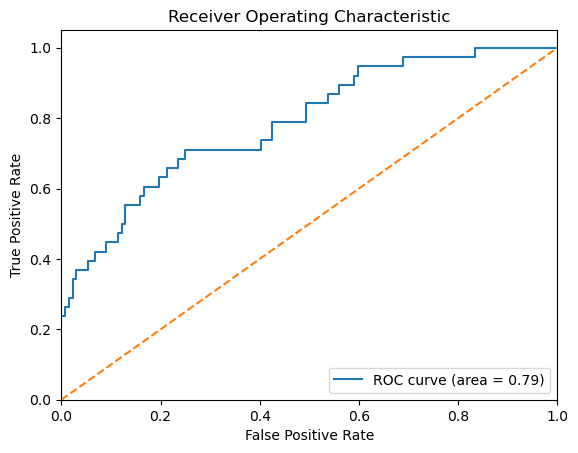

training...
0      0
3      0
9      0
12     0
15     0
      ..
825    0
832    1
837    0
839    0
847    0
Name: TRUTH, Length: 170, dtype: int32


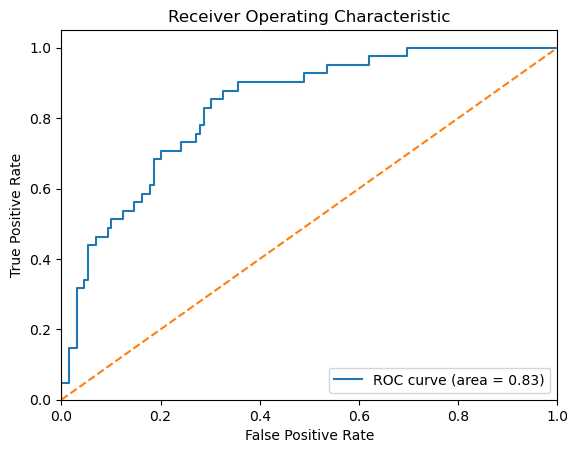

training...
8      0
16     0
17     0
26     0
36     0
      ..
822    1
823    0
827    0
833    1
836    0
Name: TRUTH, Length: 169, dtype: int32


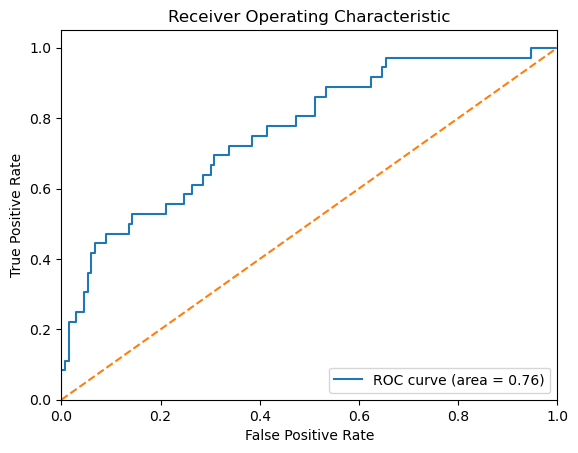

training...
1      0
4      1
13     0
14     0
20     0
      ..
809    0
826    0
830    0
841    0
845    0
Name: TRUTH, Length: 169, dtype: int32


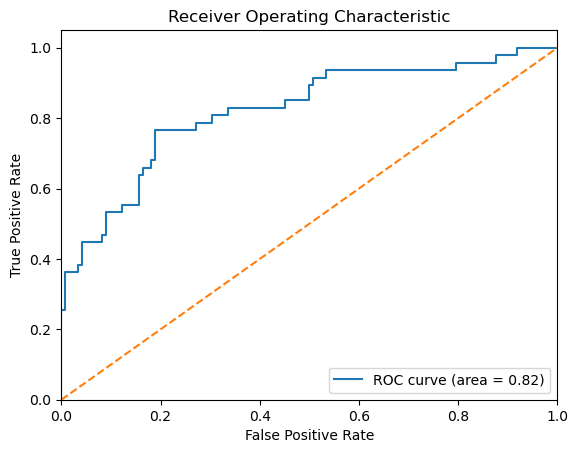

In [29]:
# best =  search.best_params_

X = full_df.drop(["TRUTH"], axis=1)
y = full_df["TRUTH"]

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

outer_scores = []
best_params_outer = []

for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    thing = GradientBoostingEstimator(gb_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1.0)

    print("training...")
    thing.fit(X_train, y_train)
    thing.predict(X_test)
    thing.score(X_test, y_test)

    from sklearn.metrics import roc_curve

    # Ensure your estimator has a method to predict probabilities
    # Typically, you would use .predict_proba() to get the probabilities
    y_scores = thing.predict_proba(X_test)[:, 1]  # get probabilities for the positive class

    print(y_test)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")

    plt.savefig("grad_boost_roc_curve.png")  # Save the plot before showing it
    plt.show()
    # plt.show()


## XGBoost: imblearn pipeline SMOTE

In [22]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imblearnPipeline
from xgboost import XGBClassifier

xgb_smote_pipeline = imblearnPipeline([
    ("smote", SMOTE()),  # SMOTE for oversampling
    ("xgb_estimator", XGBClassifier(use_label_encoder=False, eval_metric="logloss")),
    # XGBoost estimator: has paramters n_estimators, learning_rate.
])

param_grid = {
    "smote__sampling_strategy": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "xgb_estimator__n_estimators": range(100, 500, 100),
    "xgb_estimator__learning_rate": [0.01, 0.1, 0.2],
}

In [23]:
import numpy as np
from sklearn.model_selection import KFold


def nested_cv_xg(X, y):
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    outer_scores = []
    best_params_outer = []

    for train_idx, test_idx in outer_cv.split(X):

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        grid_search = GridSearchCV(xgb_smote_pipeline, param_grid, scoring=make_scorer(balanced_accuracy_score), cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_params_outer.append(grid_search.best_params_)

        best_model = grid_search.best_estimator_
        test_score = best_model.score(X_test, y_test)
        outer_scores.append(test_score)

    print("Outer CV scores: ", outer_scores)
    print("Mean balanced accuracy score: ", np.mean(outer_scores))
    print("Best parameters for each outer fold: ", best_params_outer)


In [ ]:
for visit in range(1, 5):
    full_df = transform_data(original_data, visit, 6)
    print("start visit: " + str(visit))
    X = full_df.drop(["TRUTH"], axis=1)
    y = full_df["TRUTH"]

    nested_cv_xg(X, y)

start visit: 1
Outer CV scores:  [0.7058823529411765, 0.8058823529411765, 0.8058823529411765, 0.8106508875739645, 0.7633136094674556]
Mean balanced accuracy score:  0.7783223111729899
Best parameters for each outer fold:  [{'smote__sampling_strategy': 0.8, 'xgb_estimator__learning_rate': 0.01, 'xgb_estimator__n_estimators': 300}, {'smote__sampling_strategy': 0.9, 'xgb_estimator__learning_rate': 0.2, 'xgb_estimator__n_estimators': 100}, {'smote__sampling_strategy': 1, 'xgb_estimator__learning_rate': 0.1, 'xgb_estimator__n_estimators': 100}, {'smote__sampling_strategy': 0.6, 'xgb_estimator__learning_rate': 0.1, 'xgb_estimator__n_estimators': 200}, {'smote__sampling_strategy': 1, 'xgb_estimator__learning_rate': 0.01, 'xgb_estimator__n_estimators': 100}]
start visit: 2
Outer CV scores:  [0.788235294117647, 0.8058823529411765, 0.7941176470588235, 0.7988165680473372, 0.8106508875739645]
Mean balanced accuracy score:  0.7995405499477897
Best parameters for each outer fold:  [{'smote__sampling

## Random Forest Pipeline: imblearn pipeline

In [29]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imblearnPipeline
from sklearn.ensemble import RandomForestClassifier

rf_smote_pipeline = imblearnPipeline([
    ("smote", SMOTE()),  # SMOTE for oversampling
    ("rf_estimator", RandomForestClassifier(random_state=42)),
])

param_grid = {
    "smote__sampling_strategy": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "rf_estimator__n_estimators": range(100, 500, 100),
    "rf_estimator__max_depth": [10, 20, 30, None],
    # max features > 0.25
    # 'rf_estimator__max_features': ['auto', 'sqrt', 0.25, 0.5, 0.75],  # Adjust percentages as needed
    # 'rf_estimator__min_samples_split': [2, 5, 10],
    # 'rf_estimator__min_samples_leaf': [1, 2, 4],
    "rf_estimator__bootstrap": [True, False],  # just set it true unless we have concerns about having enough signal
    "rf_estimator__criterion": ["gini", "entropy"],  # just pick one
}
# rf_grid_search = GridSearchCV(rf_smote_pipeline, param_grid, scoring=make_scorer(balanced_accuracy_score), cv=5, n_jobs=-1)


In [30]:
import numpy as np
from sklearn.model_selection import KFold

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

outer_scores = []
best_params_outer = []

for train_idx, test_idx in outer_cv.split(X):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    grid_search = GridSearchCV(rf_smote_pipeline, param_grid, scoring=make_scorer(balanced_accuracy_score), cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params_outer.append(grid_search.best_params_)

    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    outer_scores.append(test_score)

print("Outer CV scores: ", outer_scores)
print("Mean balanced accuracy score: ", np.mean(outer_scores))
print("Best parameters for each outer fold: ", best_params_outer)


Outer CV scores:  [0.7058823529411765, 0.7705882352941177, 0.788235294117647, 0.7988165680473372, 0.7988165680473372]
Mean balanced accuracy score:  0.7724678036895231
Best parameters for each outer fold:  [{'rf_estimator__bootstrap': True, 'rf_estimator__criterion': 'entropy', 'rf_estimator__max_depth': 20, 'rf_estimator__n_estimators': 100, 'smote__sampling_strategy': 1}, {'rf_estimator__bootstrap': False, 'rf_estimator__criterion': 'gini', 'rf_estimator__max_depth': 20, 'rf_estimator__n_estimators': 100, 'smote__sampling_strategy': 0.6}, {'rf_estimator__bootstrap': False, 'rf_estimator__criterion': 'entropy', 'rf_estimator__max_depth': None, 'rf_estimator__n_estimators': 100, 'smote__sampling_strategy': 0.6}, {'rf_estimator__bootstrap': True, 'rf_estimator__criterion': 'entropy', 'rf_estimator__max_depth': 10, 'rf_estimator__n_estimators': 300, 'smote__sampling_strategy': 0.9}, {'rf_estimator__bootstrap': True, 'rf_estimator__criterion': 'entropy', 'rf_estimator__max_depth': 10, 'rf

## Data

In [ ]:
# test_df = flat_df.sample(n=len(flat_df)//5, random_state=seed)  # Sampling test data
# train_df = flat_df.drop(test_df.index)  # Dropping test data from training set

X_train = flat_train_df.drop("TRUTH", axis=1)
y_train = flat_train_df["TRUTH"]

In [ ]:
# # Prepare test data
X_test = flat_test_df.drop("TRUTH", axis=1)
y_test = flat_test_df["TRUTH"]


In [ ]:
(y_train == 0).sum()

In [ ]:
import numpy as np
import pandas as pd


def check_data_leakage(X_train, X_test):
    common_columns = X_train.columns.intersection(X_test.columns)

    X_train_common = X_train[common_columns].reset_index(drop=True)
    X_test_common = X_test[common_columns].reset_index(drop=True)

    train_rows = set([tuple(row) for row in X_train_common.to_numpy()])
    test_rows = set([tuple(row) for row in X_test_common.to_numpy()])

    leakage_rows = train_rows.intersection(test_rows)
    num_leakage_rows = len(leakage_rows)

    if num_leakage_rows > 0:
        print(f"Data leakage detected: {num_leakage_rows} overlapping rows found.")
    else:
        print("No data leakage detected in rows.")

    for column in common_columns:
        train_values = set(X_train[column].dropna())
        test_values = set(X_test[column].dropna())

        common_values = train_values.intersection(test_values)
        num_common_values = len(common_values)

        overlap_percentage = num_common_values / max(len(train_values), len(test_values)) * 100

        if overlap_percentage > 10:
            print(f"Data leakage detected in column '{column}': {overlap_percentage:.2f}% overlap.")

    return "Leakage check complete."


check_data_leakage(X_train, X_test)

In [ ]:
(X_train["CDRGLOB_1"] == 0).sum() / len(X_train["CDRGLOB_1"])

# Extra Code

## Halving Random Search CV

#### Gradient Boosting

In [59]:
import numpy as np

seed = 42

# Parameter distributions
param_distributions = {
    "oversample_ratio": [1, 2, 3, 4, 5, 6],  # Example range for SMOTE ratio
    "undersample_ratio": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "lasso_alpha": [x / 10 for x in range(10)],
    "gb_estimators": range(100, 500, 100),     # Example range for RF estimators
}

# Create the HalvingRandomSearchCV instance
search = HalvingRandomSearchCV(estimator=GradientBoostingEstimator_old(),
                               param_distributions=param_distributions,
                               n_jobs=-1,  # Use all cores
                               cv=5)

# Fit the model (using your data)
search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", search.best_params_)

smote:  6 1
{1: 996} {0: 51}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (996) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


Best Parameters: {'undersample_ratio': 1, 'oversample_ratio': 6, 'lasso_alpha': 0.3, 'gb_estimators': 400}


In [61]:
best = search.best_params_

thing = GradientBoostingEstimator_old(undersample_ratio=best["undersample_ratio"], gb_estimators=best["gb_estimators"], oversample_ratio=best["oversample_ratio"], lasso_alpha=best["lasso_alpha"])

thing.fit(X_train, y_train)
thing.predict(X_test)
thing.score(X_test, y_test)

import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

# Ensure your estimator has a method to predict probabilities
# Typically, you would use .predict_proba() to get the probabilities
y_scores = thing.predict_proba(X_test)[:, 1]  # get probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


smote:  6 1
{1: 996} {0: 51}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (996) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


0.6150320013838436

#### XGBoost

In [132]:
import numpy as np
from sklearn.model_selection import HalvingRandomSearchCV

seed = 42

# Parameter distributions
param_distributions = {
    "oversample_ratio": [1, 2, 3, 4, 5, 6],  # Example range for SMOTE ratio
    "undersample_ratio": [0.5, 0.6, 0.7, 0.8, 0.9, 1],     # Example range for LASSO alpha
    "lasso_alpha": [x / 10 for x in range(10)],
    "xgb_estimators": range(100, 500, 100),     # Example range for RF estimators
}

# Create the HalvingRandomSearchCV instance
search = HalvingRandomSearchCV(estimator=XGBoostEstimator(),
                               param_distributions=param_distributions,
                               n_jobs=-1,  # Use all cores
                               cv=5)

# Fit the model (using your data)
search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", search.best_params_)


smote:  1 1
{1: 166} {0: 51}
Best Parameters: {'xgb_estimators': 200, 'undersample_ratio': 1, 'oversample_ratio': 1, 'lasso_alpha': 0.5}


In [133]:
best = search.best_params_

thing = XGBoostEstimator(undersample_ratio=best["undersample_ratio"], xgb_estimators=best["xgb_estimators"], oversample_ratio=best["oversample_ratio"], lasso_alpha=best["lasso_alpha"])

thing.fit(X_train, y_train)
thing.predict(X_test)
thing.score(X_test, y_test)

smote:  1 1
{1: 166} {0: 51}


0.5844144611658882

#### Random Forest

In [124]:
import numpy as np
from sklearn.model_selection import HalvingRandomSearchCV

seed = 42

# Parameter distributions
param_distributions = {
    "oversample_ratio": [1, 2, 3, 4, 5, 6],  # Example range for SMOTE ratio
    "undersample_ratio": [0.5, 0.6, 0.7, 0.8, 0.9, 1],     # Example range for LASSO alpha
    "lasso_alpha": [x / 10 for x in range(10)],
    "rf_estimators": range(100, 500, 100),     # Example range for RF estimators
}

# Create the HalvingRandomSearchCV instance
search = HalvingRandomSearchCV(estimator=RandomForestEstimator(),
                               param_distributions=param_distributions,
                               n_jobs=-1,  # Use all cores
                               cv=5)


# Fit the model (using your data)
search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", search.best_params_)


smote:  3 1
{1: 498} {0: 51}


C:\Users\tminh\AppData\Local\Temp\ipykernel_29484\4146061765.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X, y)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e+01, tolerance: 4.626e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Best Parameters: {'undersample_ratio': 1, 'rf_estimators': 100, 'oversample_ratio': 3, 'lasso_alpha': 0.0}


In [125]:
best = search.best_params_

thing = RandomForestEstimator(undersample_ratio=best["undersample_ratio"], rf_estimators=best["rf_estimators"], oversample_ratio=best["oversample_ratio"], lasso_alpha=best["lasso_alpha"])

thing.fit(X_train, y_train)
thing.predict(X_test)
thing.score(X_test, y_test)

smote:  3 1
{1: 498} {0: 51}


C:\Users\tminh\AppData\Local\Temp\ipykernel_29484\4146061765.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X, y)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e+01, tolerance: 4.626e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.5778412039439543

## Grid Search CV

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV

seed = 42

# Parameter grid
param_grid = {
    "oversample_ratio": [1, 2, 3, 4, 5, 6],  # Example values for oversample ratio
    "undersample_ratio": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  # Example values for undersample ratio
    "lasso_alpha": [0.1 * x for x in range(10)],  # Example values for LASSO alpha
    "rf_estimators": list(range(100, 501, 100)),  # Example values for RF estimators (100, 200, 300, 400, 500)
}

# Create the GridSearchCV instance
search = GridSearchCV(estimator=RandomForestEstimator(),
                      param_grid=param_grid,
                      n_jobs=-1,  # Use all cores
                      cv=5)

test_df = flat_df.sample(n=len(flat_df) // 10, random_state=seed)
train_df = flat_df.drop(test_df.index)

X_train = train_df.drop("TRUTH", axis=1)
y_train = train_df["TRUTH"]

# Fit the model (using your data)
search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", search.best_params_)


In [ ]:
best = {"undersample_ratio": 0.5, "rf_estimators": 300, "oversample_ratio": 3, "lasso_alpha": 0.2}

thing = RandomForestEstimator(undersample_ratio=best["undersample_ratio"], rf_estimators=best["rf_estimators"], oversample_ratio=best["oversample_ratio"], lasso_alpha=best["lasso_alpha"])
test_df = flattened_df.sample(n=len(flattened_df) // 5, random_state=seed)
train_df = flattened_df.drop(test_df.index)

X_train = train_df.drop("TRUTH", axis=1)
y_train = train_df["TRUTH"]

X_test = test_df.drop("TRUTH", axis=1)
y_test = test_df["TRUTH"]

thing.fit(X_train, y_train)
thing.predict(X_test)
thing.score(X_test, y_test)

Fixes needed:

use uniform distribution

try grid search

# Extra Utilities

## Sampling Heatmap Generation Pipeline

In [29]:
def lets_heatmap(accuracies, name):
    df_accuracies = pd.DataFrame(accuracies,
                             index=["100%", "150%", "200%", "250%", "300%"],
                             columns=["50%", "60%", "70%", "80%", "90%", "100%"])

    plt.figure(figsize=(10, 8))
    sns.heatmap(df_accuracies, annot=True, cmap="viridis", cbar_kws={"label": "Accuracy"})
    plt.xlabel("Undersample Percentage of Class 0")
    plt.ylabel("Oversample Percentage of Class 1")
    plt.title("Heatmap of Model Accuracies")
    plt.savefig(name, dpi=300, bbox_inches="tight")
    plt.show()

### Classifier Functions

In [31]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.metrics import balanced_accuracy_score, classification_report


# Modify the function to train a Gradient Boosting model
def gradient_boosting(train_df, test_df, truth_col):

    X_train = train_df.drop(columns=[truth_col])
    y_train = train_df[truth_col]

    # Train a Gradient Boosting Classifier
    model = GradientBoostingClassifier(random_state=2, n_estimators=400)
    model.fit(X_train, y_train)

    X_test = test_df.drop(columns=[truth_col])
    y_test = test_df[truth_col]

    y_pred = model.predict(X_test)

    accuracy = balanced_accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # return model, accuracy, report
    return accuracy


In [21]:
# LOGREG

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def logreg(train_df, test_df, truth_col):
    X_train = train_df.drop(columns=[truth_col])
    y_train = train_df[truth_col]

    model = LogisticRegression()
    model.fit(X_train, y_train)

    X_test = test_df.drop(columns=[truth_col])
    y_test = test_df[truth_col]

    y_pred = model.predict(X_test)

    accuracy = balanced_accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # return model, accuracy, report
    return accuracy


# Set the column name for the target variable
target_column = "TRUTH"

# Train the logistic regression model
# model, accuracy, report = logreg(flattened_df, flattened_df, target_column)
accuracy = logreg(flat_train_df, flat_test_df, target_column)

# # Print the accuracy and classification report
print(f"Accuracy: {accuracy:.2f}")
# print("\nClassification Report:\n", report)

Accuracy: 0.50


C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

In [22]:
# RANDOM FOREST
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier


def ranfor(train_df, test_df, truth_col, hyper_estimators):
    X_train = train_df.drop(columns=[truth_col])
    y_train = train_df[truth_col]

    # Train a Random Forest Classifier
    random_forest = RandomForestClassifier(random_state=2, n_estimators=hyper_estimators)
    random_forest.fit(X_train, y_train)

    X_test = test_df.drop(columns=[truth_col])
    y_test = test_df[truth_col]
    # my brothe rin chrst
    y_pred = random_forest.predict(X_test)

    accuracy = balanced_accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    classification_report_result = classification_report(y_test, y_pred)
    # print(classification_report_result)
    return accuracy


ranfor(flat_train_df, flat_test_df, "TRUTH", 50)

print("Accuracy:", accuracy)
# print("Classification Report:\n", classification_report_result)

Accuracy: 0.5


### Simple over-sample & under-sample heatmap generator

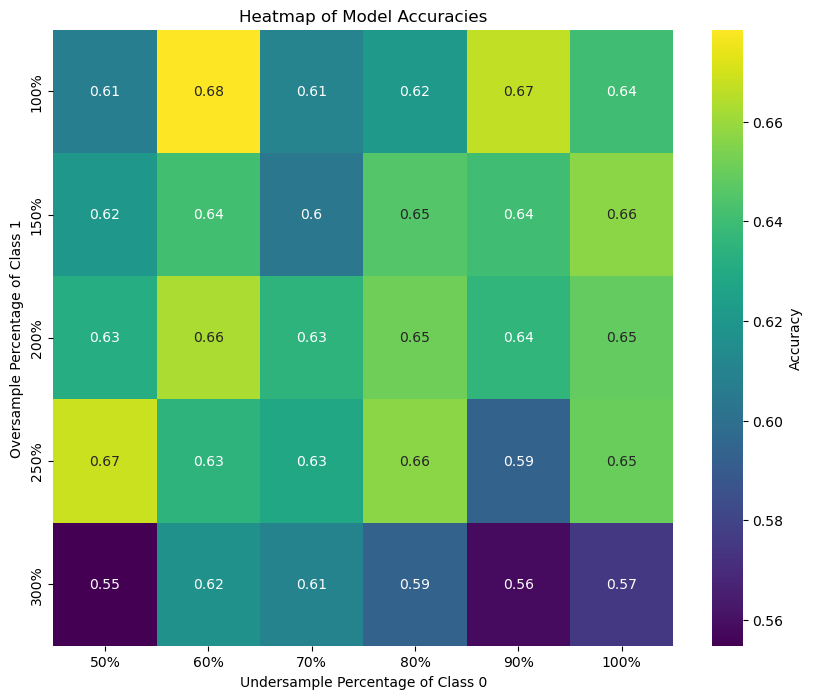

In [32]:
import pandas as pd


def run_over_under_simple(train_df, test_df, func, name, seed):

    # Assuming flattened_df is already defined
    class_0 = train_df[train_df["TRUTH"] == 0]
    class_1 = train_df[train_df["TRUTH"] == 1]

#     test_size_per_class = int(0.20 * len(flattened_df) / 2)
#     test_class_0 = class_0.sample(n=test_size_per_class, random_state=seed)
#     test_class_1 = class_1.sample(n=test_size_per_class, random_state=seed)
#     test_df = pd.concat([test_class_0, test_class_1])

#     train_df = flattened_df.drop(test_df.index)
    # class_0 = train_df[train_df['TRUTH'] == 0]
    # class_1 = train_df[train_df['TRUTH'] == 1]
    # return (test_df, train_df)

    # Initialize list to hold the generated dataframes
    generated_dfs = []

    accuracies = []

    for i in range(6, 1, -1):
        row_accuracies = []
        oversample_size = len(class_1) * i

        # For every 10% increment j from 50% to 100%
        for j in range(5, 11):
            undersample_fraction = j / 10
            undersample_size = int(len(class_0) * undersample_fraction)

            # Oversample class 1 by randomly sampling with replacement
            oversampled_class_1 = class_1.sample(n=oversample_size, replace=True, random_state=42)

            # Undersample class 0 by randomly sampling without replacement
            undersampled_class_0 = class_0.sample(n=undersample_size, replace=False, random_state=42)

            # Combine and append to the list of generated dataframes
            new_df = pd.concat([oversampled_class_1, undersampled_class_0])
            generated_dfs.append(new_df)

            func(new_df, test_df, "TRUTH")

            accuracy = func(new_df, test_df, "TRUTH")
            row_accuracies.append(accuracy)
        accuracies.append(row_accuracies)

    lets_heatmap(accuracies, name)


run_over_under_simple(flat_train_df, flat_test_df, gradient_boosting, "gradboos-simple-sampling", 42)

### SMOTE over-sample & under-sample heatmap generator

In [17]:
!pip install --upgrade numpy

Defaulting to user installation because normal site-packages is not writeable


In [33]:
def smote_over_under_simple(train_df, test_df, func, name, seed):

    class_0 = train_df[train_df["TRUTH"] == 0]
    class_1 = train_df[train_df["TRUTH"] == 1]

#     test_size_per_class = int(0.20 * len(flattened_df) / 2)
#     test_class_0 = class_0.sample(n=test_size_per_class, random_state=seed)
#     test_class_1 = class_1.sample(n=test_size_per_class, random_state=seed)
#     test_df = pd.concat([test_class_0, test_class_1])

#     train_df = flattened_df.drop(test_df.index)

    X = train_df.drop("TRUTH", axis=1)
    y = train_df["TRUTH"]

    generated_dfs = []
    accuracies = []

    for i in range(6, 1, -1):
        row_accuracies = []
        oversample_ratio = {1: int(len(class_1) * i)}

        # For every 10% increment j from 50% to 100%
        for j in range(5, 11):
            undersample_fraction = j / 10
            undersample_count = int(len(class_0) * undersample_fraction)
            undersample_ratio = {0: undersample_count}

            # Create a pipeline that first applies SMOTE and then RandomUnderSampling
            pipeline = Pipeline([
                ("o", SMOTE(sampling_strategy=oversample_ratio, random_state=42)),
                ("u", RandomUnderSampler(sampling_strategy=undersample_ratio, random_state=42)),
            ])

            print(oversample_ratio)  # {1: 606}
            print(undersample_ratio)  # {0: 289}

            # assert X is not None and y is not None, "X or y is None"
            # assert len(X) == len(y), "X and y length mismatch"

            X_res, y_res = pipeline.fit_resample(X, y)

            # Combine the features and target into a single DataFrame
            new_df = pd.concat([X_res, y_res], axis=1)

            generated_dfs.append(new_df)

            func(new_df, test_df, "TRUTH")

            accuracy = func(new_df, test_df, "TRUTH")
            row_accuracies.append(accuracy)
        accuracies.append(row_accuracies)

    return accuracies
    # return generated_dfs


accuracies = smote_over_under_simple(flat_train_df, flat_test_df, gradient_boosting, "heatmap-gradboost-SMOTE-sampling", 42)

{1: 996}
{0: 256}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (996) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 996}
{0: 307}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (996) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 996}
{0: 358}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (996) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 996}
{0: 409}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (996) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 996}
{0: 460}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (996) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 996}
{0: 512}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (996) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 830}
{0: 256}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (830) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 830}
{0: 307}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (830) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 830}
{0: 358}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (830) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 830}
{0: 409}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (830) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 830}
{0: 460}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (830) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 830}
{0: 512}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (830) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 664}
{0: 256}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (664) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 664}
{0: 307}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (664) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 664}
{0: 358}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (664) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 664}
{0: 409}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (664) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 664}
{0: 460}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (664) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 664}
{0: 512}


C:\ProgramData\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (664) in class 1 will be larger than the number of samples in the majority class (class #0 -> 512)
  warnings.warn(


{1: 498}
{0: 256}
{1: 498}
{0: 307}
{1: 498}
{0: 358}
{1: 498}
{0: 409}
{1: 498}
{0: 460}
{1: 498}
{0: 512}
{1: 332}
{0: 256}
{1: 332}
{0: 307}
{1: 332}
{0: 358}
{1: 332}
{0: 409}
{1: 332}
{0: 460}
{1: 332}
{0: 512}


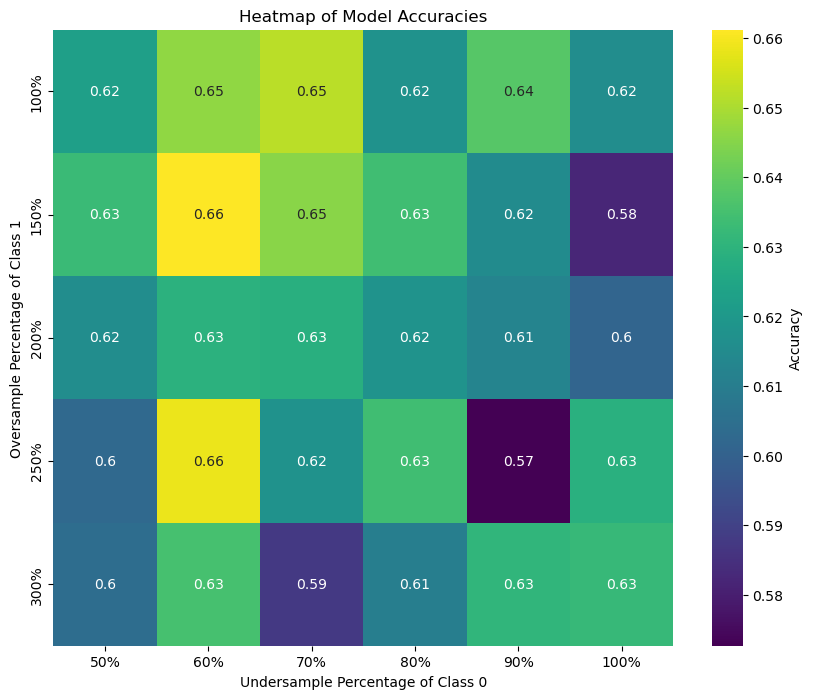

In [34]:
lets_heatmap(accuracies, "gradboost-smote")